# Importações


In [1]:
# Importações
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import LSTM
from keras.models import Sequential
from math import sqrt
from matplotlib import pyplot
import numpy
import warnings 
warnings.filterwarnings('ignore')

# Carregar dados

In [5]:
# Carregar os dados
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
series = read_csv('./dados/imiglucerase_400u.csv', header=0, parse_dates=[0], index_col=0, date_parser=dateparse)

# Tratamento dados

In [2]:
# Transformar a série temporal em um dataframe adequado para aprendizado supervisionado
def timeseries_to_supervised(data, lag=1):
 df = DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = concat(columns, axis=1)
 df.fillna(0, inplace=True)
 return df

In [3]:
# Tornar a série estacionária por diferenciação para retirar a tendência
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
 return Series(diff)

# Reverter a diferenciação para voltar a utilizar os dados
def inverse_difference(history, yhat, interval=1):
 return yhat + history[-interval]

In [4]:
# Dimensionar os dados (-1, 1)
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

# Reverter a normalização para voltar a utilizar os dados
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = numpy.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

# Modelo LSTM

In [6]:
# Treinar e retornar o modelo LSTM
def fit_lstm(train, batch_size, nb_epoch, neurons):
 X, y = train[:, 0:-1], train[:, -1]
 X = X.reshape(X.shape[0], 1, X.shape[1])
 model = Sequential()
 model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
 model.add(layers.Dense(1))
 model.compile(loss='mean_squared_error', optimizer='adam')
 for i in range(nb_epoch):
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
 return model

In [7]:
# Fazer a predição
def forecast(model, batch_size, row):
 X = row[0:-1]
 X = X.reshape(1, 1, len(X))
 yhat = model.predict(X, batch_size=batch_size)
 return yhat[0,0]

# One-step predição
def forecast_lstm(model, batch_size, X):
 X = X.reshape(1, 1, len(X))
 yhat = model.predict(X, batch_size=batch_size)
 return yhat[0,0]

In [8]:
# Transformar os dados em estacionários
raw_values = series.values
diff_values = difference(raw_values, 1)

In [9]:
# Transformar o layout do dataframe
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [10]:
# Criar as bases de treino e teste
train, test = supervised_values[0:-8], supervised_values[-8:]

In [11]:
# Dimensionar os dados
scaler, train_scaled, test_scaled = scale(train, test)

In [12]:
# Repetição da criação do modelo e predição em 30 vezes
error_scores = list()
predictions_complete = list()
for r in range(30):

  # Criar o modelo
  lstm_model = fit_lstm(train_scaled, 1, 1500, 2)

  # Treinar o modelo
  train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
  lstm_model.predict(train_reshaped, batch_size=1)

  # Validação walk-forward dos dados de teste
  predictions = list()

  for i in range(len(test_scaled)):

    # One-step predição
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)

    # Inverter a normalização
    yhat = invert_scale(scaler, X, yhat)

    # Inverter a diferenciação
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)

    # Armazenar a predição
    predictions.append(yhat)

  # Avaliar a performance
  rmse = sqrt(mean_squared_error(raw_values[-8:], predictions))
  print('Iteração %d - RMSE: %.4f' % (r+1, rmse))
  error_scores.append(rmse)

  # Salvar todos os dados previstos
  predictions_complete.append(predictions)

1/1 [==============================] - 0s 20ms/step
Iteração 1 - RMSE: 559.4455
1/1 [==============================] - 0s 21ms/step
Iteração 2 - RMSE: 642.1313
1/1 [==============================] - 0s 33ms/step
Iteração 3 - RMSE: 643.0923
1/1 [==============================] - 0s 20ms/step
Iteração 4 - RMSE: 614.1689
1/1 [==============================] - 0s 31ms/step
Iteração 5 - RMSE: 865.4424
1/1 [==============================] - 0s 20ms/step
Iteração 6 - RMSE: 831.8249
1/1 [==============================] - 0s 20ms/step
Iteração 7 - RMSE: 508.6021
1/1 [==============================] - 0s 31ms/step
Iteração 8 - RMSE: 1044.8592
1/1 [==============================] - 0s 30ms/step
Iteração 9 - RMSE: 876.2376
1/1 [==============================] - 0s 22ms/step
Iteração 10 - RMSE: 708.3851
1/1 [==============================] - 0s 26ms/step
Iteração 11 - RMSE: 805.5219
1/1 [==============================] - 0s 23ms/step
Iteração 12 - RMSE: 567.4925
1/1 [==============================]

# Resultados

## RMSE obtidos

In [13]:
# Preparação para apresentar os resultados obtidos
results = DataFrame()
results['rmse'] = error_scores

In [14]:
# Sumário do RMSE 
print("Sumário RMSE")
print(results.describe())

Sumário RMSE
              rmse
count    30.000000
mean    736.103420
std     230.415944
min     508.602124
25%     599.379452
50%     648.971810
75%     825.249150
max    1504.636391


Bloxplot RMSE


<Axes: >

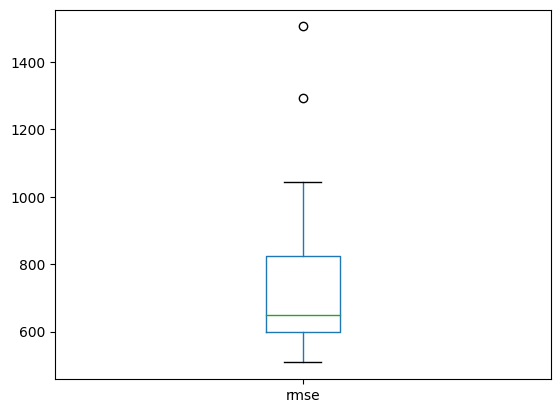

In [15]:
# Bloxplot do RMSE
print("Bloxplot RMSE")
results.boxplot(grid=False)

## Predição com menor RMSE


Menor RMSE: 508.6021


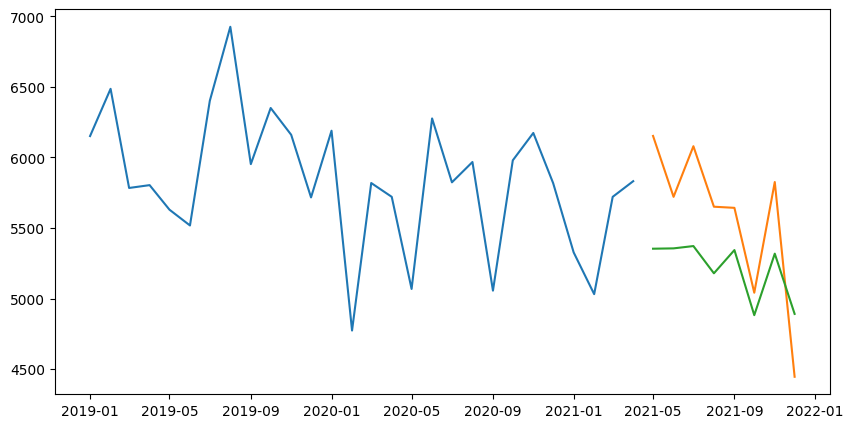

In [16]:
# Plotar a predição com menor RMSE
print('Menor RMSE: %.4f' % (min(results['rmse'])))
plotar = series.reset_index()
plotar.loc[plotar.competencia > '2021-04-01', "predictions"] = predictions_complete[results['rmse'].idxmin()]
plotar = plotar.set_index('competencia')
pyplot.figure(figsize=(10,5))
pyplot.plot(plotar['qtd_dispensada'][0:-8])
pyplot.plot(plotar['qtd_dispensada'][-8:])
pyplot.plot(plotar['predictions'])

## Predição com maior RMSE

Maior RMSE: 1504.6364


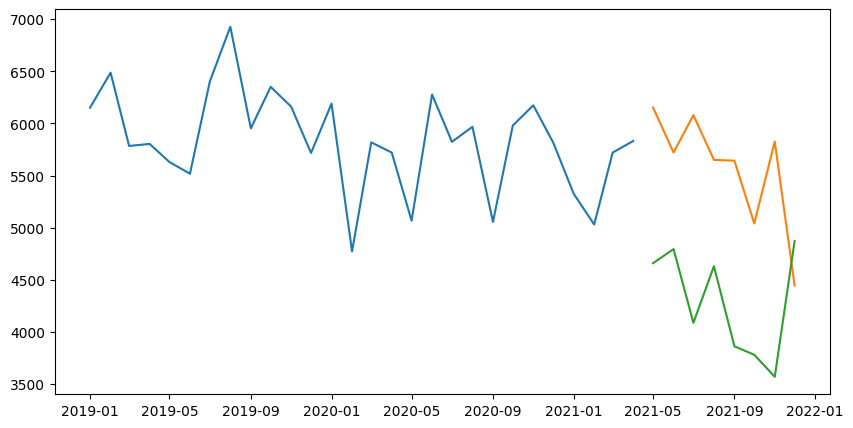

In [17]:
# Plotar a predição com maior RMSE
print('Maior RMSE: %.4f' % (max(results['rmse'])))
plotar = series.reset_index()
plotar.loc[plotar.competencia > '2021-04-01', "predictions"] = predictions_complete[results['rmse'].idxmax()]
plotar = plotar.set_index('competencia')
pyplot.figure(figsize=(10,5))
pyplot.plot(plotar['qtd_dispensada'][0:-8])
pyplot.plot(plotar['qtd_dispensada'][-8:])
pyplot.plot(plotar['predictions'])